In [3]:
%reset -f
import gc
gc.collect()

from math import *
import numpy as np

import matplotlib.pyplot as plt

import time
import random

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, SeparableConv1D, Flatten, Reshape
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dropout, LeakyReLU, Lambda
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import GradientTape
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Mean, BinaryAccuracy
from tensorflow.math import reduce_mean
from tensorflow import clip_by_value


from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [4]:
# Check available GPUs
GPU_num = len(tf.config.list_physical_devices('GPU'))
print('Num GPUs Available: ', GPU_num)

# Clean previous models
clear_session()

# Random seeds initialization
seed = 42

# From https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    if GPU_num != 0:
        # When running on the CuDNN backend, two further options must be set
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"Random seed set as {seed}")
    
set_seed(seed)

Num GPUs Available:  0
Random seed set as 42


Time step exemple values:

0.006578947368421052
0.006578947368421129
0.006578947368421018
0.006578947368421018
0.00657894736842124
0.00657894736842124
0.0065789473684207955
0.00657894736842124
0.00657894736842124
0.00657894736842124
The bins length within which a CR hit relaxes is: 10
Number of bolomenters used is: 1
TODs simulated by Samantha or Guillermo have the shape:  (900, 1060, 1)


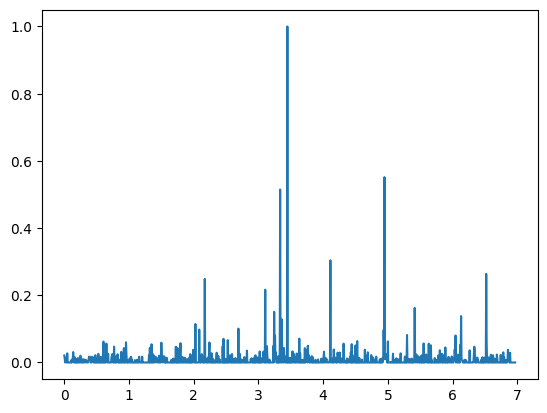

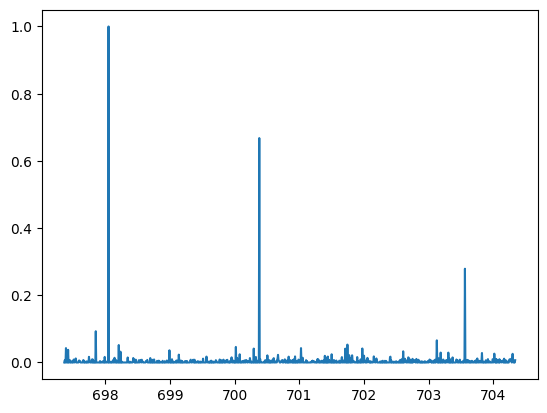

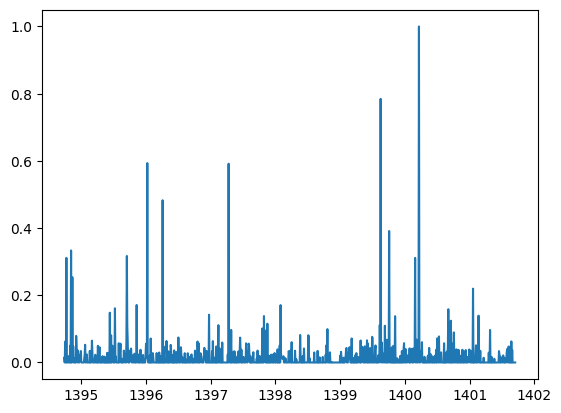

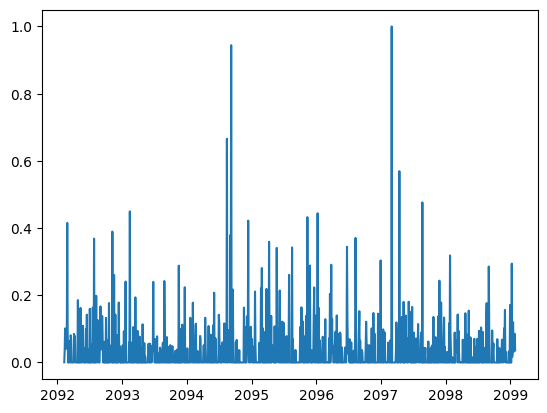

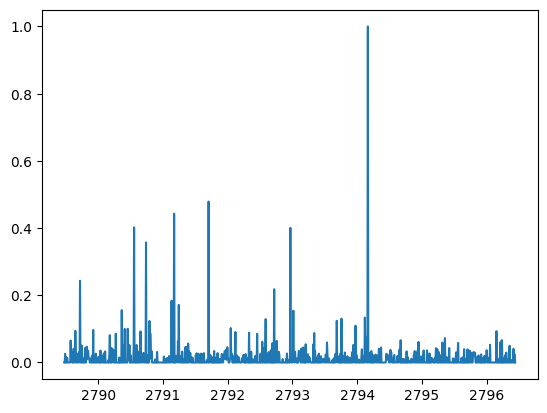

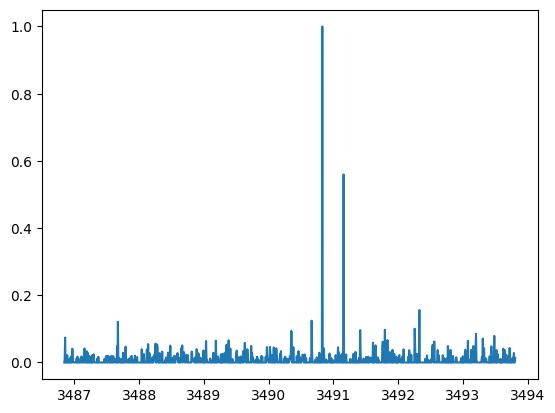

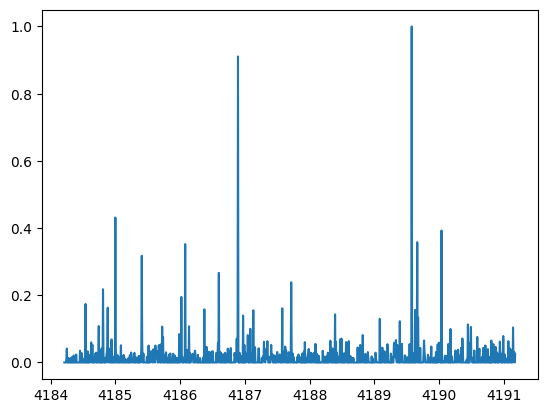

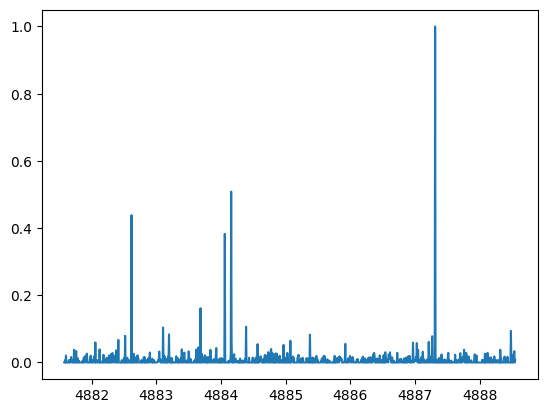

<tf.Tensor: shape=(900, 1060, 1), dtype=float64, numpy=
array([[[0.00000000e+00],
        [7.97080066e-02],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [1.99683935e-02],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [7.43656974e-05],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[8.20965706e-03],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [5.33382216e-02],
        [2.71264577e-02],
        [0.00000000e+00]],

       ...,

       [[0.00000000e+00],
        [4.12163433e-05],
        [0.00000000e+00],
        ...,
        [3.21906215e-02],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[5.49948954e-02],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [2.68875250e-02]],

       [[4.45634967e-02],
        [3.40510699e-02],
        [0.00000000e+00]

In [3]:
# Load the generated homemade TODs
data_dir = '../data'
data_file = '/gui_TOD_basic.npy' # homemade_TOD.npy, real_TOD.npy, gui_TOD_basic.npy, gui_TOD_digital.npy

with open(data_dir + data_file, 'rb') as file:
    time_steps = np.load(file)
    mins = np.load(file)
    maxs = np.load(file)
    #norm_TODs = np.load(file)
    TODs_train = np.load(file)
    #TODs_train = TODs_train[:700]
    TODs_val = np.load(file)
    
# Useful parameters
hit_len = int(0.07//(time_steps[0,2,0]-time_steps[0,1,0]))
bolom_number = 1

'''The HFT hit relax time is taken by the paper at https://www.aanda.org/articles/aa/full_html/2014/09/aa23868-14/aa23868-14.html'''

print('Time step exemple values:\n')
for i in range(10):
    print(time_steps[0,i*100+1,0]-time_steps[0,i*100,0])

print('The bins length within which a CR hit relaxes is:', hit_len)
print('Number of bolomenters used is:', bolom_number)
    
if bolom_number == 1:
    time_steps = time_steps[:,:,:1]
    TODs_train = TODs_train[:,:,:1]
    TODs_val = TODs_val[:,:,:1]
    
# Check the loaded homemade TOD
print('TODs simulated by Samantha or Guillermo have the shape: ', TODs_train.shape)

for i in range(8):
    plt.plot(time_steps[i*100,:,0], TODs_train[i*100,:,0])
    plt.show()
    
# NNs input dimension
time_bins = len(time_steps[0,:,0])
inputnoise_bins = 100

# Shuffle the training data
tf.random.shuffle(TODs_train, seed=seed)

In [4]:
# Normalization and absolute value of the synhtetic TOD

def normalize_synth(inputs):

    mins = tf.repeat(tf.math.reduce_min(inputs, axis=1), inputs.shape[1], axis=1)
    mins = tf.reshape(mins, tf.shape(inputs))
    maxs = tf.repeat(tf.math.reduce_max(inputs, axis=1), inputs.shape[1], axis=1)
    maxs = tf.reshape(maxs, tf.shape(inputs))
    
    return (inputs - mins)/(maxs-mins)

def abs_synth(inputs):
    
    return tf.math.abs(inputs)


# Normalization of the TODs and split in training and validation samples

def normalize(sample):

    mins = np.repeat(np.min(sample, axis=1), sample.shape[1], axis=1)
    mins = mins.reshape(sample.shape)
    maxs = np.repeat(np.max(sample, axis=1), sample.shape[1], axis=1)
    maxs = maxs.reshape(sample.shape)

    sample = (sample - mins)/(maxs-mins)
    
    return sample, mins, maxs

def denormalize(sample, mins, maxs):

    min_ = np.mean(mins)
    max_ = np.mean(maxs)
    sample = min_ + (max_-min_)*(sample)
  
    return sample

In [5]:
# GAN class wrapping generator-discriminator couple
class GAN(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, extra_discr=0, val_data=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        '''self.add_metric(Mean(), name="gen_loss")
        self.add_metric(Mean(), name="discr_real_loss")
        self.add_metric(Mean(), name="discr_fake_loss")
        self.add_metric(BinaryAccuracy(), name="gen_acc")
        self.add_metric(BinaryAccuracy(), name="discr_real_acc")
        self.add_metric(BinaryAccuracy(), name="discr_fake_acc")'''
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_real_loss_tracker = Mean(name="discr_real_loss")
        self.discr_fake_loss_tracker = Mean(name="discr_fake_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_real_val_loss_tracker = Mean(name="discr_real_loss_val")
        self.discr_synth_val_loss_tracker = Mean(name="discr_synth_loss_val")
        
        self.gen_acc_tracker = BinaryAccuracy(name="gen_acc", threshold=0.5)
        self.discr_real_acc_tracker = BinaryAccuracy(name="discr_real_acc", threshold=0.5)
        self.discr_synth_acc_tracker = BinaryAccuracy(name="discr_synth_acc", threshold=0.5)
        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_real_loss_tracker, self.discr_fake_loss_tracker,
                self.gen_loss_val_tracker, self.discr_real_val_loss_tracker, self.discr_synth_val_loss_tracker,
                self.gen_acc_tracker, self.discr_real_acc_tracker, self.discr_synth_acc_tracker]
    
    @tf.function    
    def train_step(self, real_data):
        
        #real_data, val_data = train_test_split(real_data, test_size=val_split)
        
        val_size = self.val_data.shape[0]
        batch_size = real_data.shape[0]
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
                
        # Train the discriminator
        for i in range(self.extra_discr+1):
            
            with GradientTape() as disc_real_tape, GradientTape() as disc_fake_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=True)
                fake_preds = self.discriminator(fake_data, training=True)

                discr_real_loss, discr_fake_loss = self.discr_loss(real_preds, fake_preds)

            discr_real_grad = disc_real_tape.gradient(discr_real_loss, self.discriminator.trainable_variables)      
            self.discr_optimizer.apply_gradients(zip(discr_real_grad, self.discriminator.trainable_variables))

            discr_fake_grad = disc_fake_tape.gradient(discr_fake_loss, self.discriminator.trainable_variables)      
            self.discr_optimizer.apply_gradients(zip(discr_fake_grad, self.discriminator.trainable_variables))
        
        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_TODs_val = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_real_loss_val, discr_fake_loss_val = self.discr_loss(real_preds_val, synth_preds_val)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_real_loss':
                m.update_state(discr_real_loss)
            if m.name == 'discr_fake_loss':
                m.update_state(discr_fake_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_real_loss_val':
                m.update_state(discr_real_loss_val)
            if m.name == 'discr_synth_loss_val':
                m.update_state(discr_fake_loss_val)
                
            if m.name == 'gen_acc':
                m.update_state(np.ones(val_size), synth_preds_val)
            if m.name == 'discr_real_acc':
                m.update_state(np.ones(val_size), real_preds_val)
            if m.name == 'discr_synth_acc':
                m.update_state(np.zeros(val_size), synth_preds_val)
        
        '''self.gen_loss_tracker.update_state(gen_loss)
        self.discr_real_loss_tracker.update_state(discr_real_loss)
        self.discr_fake_loss_tracker.update_state(discr_fake_loss)
        
        self.gen_acc_tracker.update_state(np.ones(batch_size), synth_preds)
        self.discr_real_acc_tracker.update_state(np.ones(batch_size), real_preds)
        self.discr_fake_acc_tracker.update_state(np.zeros(batch_size), fake_preds)'''
        
        return {m.name: m.result() for m in self.metrics}
    
        '''"gen_loss": self.gen_loss_tracker.result(), "discr_real_loss": self.discr_real_loss_tracker.result(),
        "discr_fake_loss": self.discr_fake_loss_tracker.result(),'''

In [6]:
# GAN class wrapping generator-discriminator couple
class GAN_1(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight=1, extra_discr=1, val_data=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.synth_weight = synth_weight
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_val_loss_tracker = Mean(name="discr_loss_val")

        self.gen_acc_tracker = BinaryAccuracy(name="gen_acc", threshold=0.5)
        self.discr_acc_tracker = BinaryAccuracy(name="discr_acc", threshold=0.5)
        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_loss_tracker,
                self.gen_loss_val_tracker, self.discr_val_loss_tracker,
                self.gen_acc_tracker, self.discr_acc_tracker]
    
    @tf.function    
    def train_step(self, real_data):
        
        val_size = self.val_data.shape[0]
        
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
        
        # Use the pre-trained discriminator
        if self.extra_discr == 0:

            with GradientTape() as disc_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=False)
                fake_preds = self.discriminator(fake_data, training=False)

                discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

        # Train the discriminator
        else:
            
            for i in range(self.extra_discr):

                with GradientTape() as disc_tape:

                    fake_data = self.generator(inputnoise, training=False)
                    real_preds = self.discriminator(real_data, training=True)
                    fake_preds = self.discriminator(fake_data, training=True)

                    discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

                discr_grad = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)      
                self.discr_optimizer.apply_gradients(zip(discr_grad, self.discriminator.trainable_variables))

        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_TODs_val = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_loss_val = self.discr_loss(real_preds_val, synth_preds_val, self.synth_weight)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_loss':
                m.update_state(discr_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_loss_val':
                m.update_state(discr_loss_val)
                
            if m.name == 'gen_acc':
                m.update_state(np.ones(val_size), synth_preds_val)
            if m.name == 'discr_acc':
                m.update_state(tf.concat([np.ones(val_size), np.zeros(val_size)], 0), tf.concat([real_preds_val, synth_preds_val], 0))
                
        return {m.name: m.result() for m in self.metrics}

In [7]:
# WGAN class wrapping generator-critic couple
class WGAN(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight=1, extra_discr=1, val_data=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.synth_weight = synth_weight
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_val_loss_tracker = Mean(name="discr_loss_val")

        self.gen_response_tracker = Mean(name="gen_response")
        self.discr_real_response_tracker = Mean(name="discr_real_response")
        self.discr_synth_response_tracker = Mean(name="discr_synth_response")

        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_loss_tracker,
                self.gen_loss_val_tracker, self.discr_val_loss_tracker,
                self.gen_response_tracker, self.discr_real_response_tracker, self.discr_synth_response_tracker]
    
    @tf.function    
    def train_step(self, real_data):
        
        val_size = self.val_data.shape[0]
        
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
        
        # Use the pre-trained discriminator
        if self.extra_discr == 0:

            with GradientTape() as disc_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=False)
                fake_preds = self.discriminator(fake_data, training=False)

                discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

        # Train the discriminator
        else:
            
            for i in range(self.extra_discr):

                with GradientTape() as disc_tape:

                    fake_data = self.generator(inputnoise, training=False)
                    real_preds = self.discriminator(real_data, training=True)
                    fake_preds = self.discriminator(fake_data, training=True)

                    discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

                discr_grad = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)      
                self.discr_optimizer.apply_gradients(zip(discr_grad, self.discriminator.trainable_variables))

                for w in self.discriminator.trainable_variables:
                
                    w.assign(clip_by_value(w, -1., 1.))

        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))

        for w in self.discriminator.trainable_variables:
                
                w.assign(clip_by_value(w, -1., 1.))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_TODs_val = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_loss_val = self.discr_loss(real_preds_val, synth_preds_val, self.synth_weight)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_loss':
                m.update_state(discr_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_loss_val':
                m.update_state(discr_loss_val)
                
            if m.name == 'gen_response':
                m.update_state(synth_preds_val)
            if m.name == 'discr_real_response':
                m.update_state(real_preds_val)
            if m.name == 'discr_synth_response':
                m.update_state(fake_preds)
            
        return {m.name: m.result() for m in self.metrics}

In [8]:
# Custom sparsely connected layer
class SparseFullyConnected(tf.keras.layers.Layer):
    def __init__(self, out_dim, conn, activation=None):
        super().__init__()
        self.out_dim = out_dim
        self.conn = conn
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=(input_shape[-1], self.out_dim), initializer="glorot_uniform")
        self.bias = self.add_weight("bias", shape=(self.out_dim,), initializer="zeros")

    def call(self, inputs):
        connected_values = tf.math.top_k(inputs, k=self.conn).values
        output = tf.matmul(connected_values, self.kernel) + self.bias

        if self.activation is not None:
            output = self.activation(output)

        return output

class NN_list():
    
    def __init__(self, time_bins, inputnoise_bins, hit_len):
        
        super().__init__()
        self.generator_names = ['simple_generator_model', 'empty_generator_model', 'real_generator_model', 'real_empty_generator_model', 'wide_generator_model']
        self.discriminator_names = ['simple_discriminator_model', 'simple_critic_model_relu', 'simple_critic_model_smooth', 'real_discriminator_model']
        self.generators = [simple_generator_model(time_bins, inputnoise_bins, hit_len), empty_generator_model(time_bins, inputnoise_bins), real_generator_model(time_bins, inputnoise_bins, hit_len), real_empty_generator_model(time_bins, inputnoise_bins), wide_generator_model(time_bins, inputnoise_bins, hit_len)]
        self.discriminators = [simple_discriminator_model(time_bins), simple_critic_model_relu(time_bins), simple_critic_model_smooth(time_bins), real_discriminator_model(time_bins, hit_len)]

# ----------------------------------------------------

# Define simplest Generator and discriminator models of GAN
def simple_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=inputnoise_bins),
        Dense(time_bins//6),
        LeakyReLU(),
        Reshape((time_bins//6, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 3, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(1, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

def simple_discriminator_model(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(8, 2*hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(32, hit_len, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model

def simple_critic_model_relu(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(10, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = hit_len, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

def simple_critic_model_smooth(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(10, hit_len//2, padding='same', strides = 1, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = 1, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = 2, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = hit_len//2, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

# Define a test empty generator
def empty_generator_model(time_bins, inputnoise_bins):
    
    model = Sequential([
        Input(shape=inputnoise_bins),
        Dense(time_bins//12, trainable=False),
        Reshape((time_bins//12, 1)),
        Conv1DTranspose(1, 12, padding='same', strides = 12, data_format='channels_last', trainable=False)],
        name='Empty_generator')
    
    return model

# ----------------------------------------------------

# Define the Generator and discriminator models of GAN for the Samantah and Guillermo data
def real_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//4),
        LeakyReLU(),
        Reshape((time_bins//4, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(bolom_number, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

def real_discriminator_model(time_bins, hit_len):
    
    model = Sequential([
        Input(shape=(time_bins, bolom_number,)),
        Conv1D(8, 2*hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(32, hit_len, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model
    
# Define a test empty generator
def real_empty_generator_model(time_bins, inputnoise_bins):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//10, trainable=False),
        Reshape((time_bins//10, 1)),
        Conv1DTranspose(bolom_number, 10, padding='same', strides = 10, data_format='channels_last', trainable=False)],
        name='Empty_generator')
    
    return model

# ----------------------------------------------------

# Define wide Generator and discriminator models of GAN
def wide_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//4),
        LeakyReLU(),
        Reshape((time_bins//4, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(bolom_number, hit_len, padding='same', strides = 1, data_format='channels_last'),
        Reshape((bolom_number*time_bins,)),
        Dense(time_bins),
        LeakyReLU(),
        Reshape((time_bins, bolom_number,)),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

# ----------------------------------------------------

# Define the Generator and discriminator models of GAN for the Samantah and Guillermo data and their transformated
def multiple_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//4),
        LeakyReLU(),
        Reshape((time_bins//4, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(bolom_number, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

def multiple_discriminator_model(time_bins, hit_len):
    
    model = Sequential([
        Input(shape=(time_bins, bolom_number,)),
        Conv1D(8, 2*hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(32, hit_len, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model
    
# Define a test empty generator
def multiple_empty_generator_model(time_bins, inputnoise_bins):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//10, trainable=False),
        Reshape((time_bins//10, 1)),
        Conv1DTranspose(bolom_number, 10, padding='same', strides = 10, data_format='channels_last', trainable=False)],
        name='Empty_generator')
    
    return model


# Definition of loss functions with binary cross entropy between the NNs predictions and correct labels for
# both GAN and WGAN
model_struct = 'GAN_1'

if model_struct == 'GAN':
    
    cross_entropy = BinaryCrossentropy(from_logits=False)

    def gen_loss(synth_preds):

        return cross_entropy(np.ones(synth_preds.shape), synth_preds)

    def discr_loss(real_preds, synth_preds):

        real_loss = cross_entropy(np.ones(real_preds.shape), real_preds)
        synth_loss = cross_entropy(np.zeros(synth_preds.shape), synth_preds)

        return real_loss, synth_loss
    
if model_struct == 'GAN_1':
    
    cross_entropy_gen = BinaryCrossentropy(from_logits=False, label_smoothing=0.1)
    cross_entropy_discr = BinaryCrossentropy(from_logits=False, label_smoothing=0.)

    def gen_loss(synth_preds):

        return cross_entropy_gen(np.ones(synth_preds.shape), synth_preds)

    def discr_loss(real_preds, synth_preds, synth_weight):

        real_loss = cross_entropy_discr(np.ones(real_preds.shape), real_preds, sample_weight=1)
        synth_loss = cross_entropy_discr(np.zeros(synth_preds.shape), synth_preds, sample_weight=synth_weight)

        return real_loss + synth_loss

if model_struct == 'WGAN':

    def gen_loss(synth_preds):

        return - reduce_mean(synth_preds)

    def discr_loss(real_preds, synth_preds, sample_weight):

        real_loss = reduce_mean(real_preds)
        synth_loss = sample_weight*reduce_mean(synth_preds)

        return synth_loss - real_loss


# Show the implemented NN structures for the GAN model
models_list = NN_list(time_bins, inputnoise_bins, hit_len)

for i in range(len(models_list.generator_names)):
    print(f'The structure of the generator {models_list.generator_names[i]} model is:')
    show_model = models_list.generators[i]
    show_model.summary()
    
for i in range(len(models_list.discriminator_names)):
    print(f'The structure of the generator {models_list.discriminator_names[i]} model is:\n')
    models_list.discriminators[i].summary()

The structure of the generator simple_generator_model model is:
Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 176)               17776     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 176)               0         
                                                                 
 reshape (Reshape)           (None, 176, 1)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 176, 8)            88        
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 176, 8)            0         
                                                                 
 batch_normalization (Batch  (None, 176, 8)            32  

In [9]:
# Set the optimizers and train parameters
batch_size = 64
epochs = 20
lr = 1e-3
momentum = 0.5
synth_weight = 0.5

# Optimizer
optim = 'SGD'

if optim == 'SGD':
    gen_optimizer = SGD(learning_rate=lr, momentum=momentum)
    discr_optimizer = SGD(learning_rate=lr, momentum=momentum)
    
if optim == 'Adam':
    gen_optimizer = Adam(learning_rate=lr)
    discr_optimizer = Adam(learning_rate=lr)
    
if optim == 'Nadam':
    gen_optimizer = Nadam(learning_rate=lr)
    discr_optimizer = Nadam(learning_rate=lr)

val_split = 0.1

# Create the directory to save the result plots
model_dir = '../models/gui_basic_gan_28'
! rm -r {model_dir}
! mkdir {model_dir}

# Build the GAN (only discriminator)
gen_empty = real_empty_generator_model(time_bins, inputnoise_bins)
discr_pretrain = real_discriminator_model(time_bins, hit_len)
gen_empty.summary()
discr_pretrain.summary()

with open(model_dir + '/model_summary.txt', 'w') as f:
    gen_empty.summary(print_fn=lambda x: f.write(x + '\n'))
    discr_pretrain.summary(print_fn=lambda x: f.write(x + '\n'))

if model_struct == 'GAN_1':
    gan_pretrain = GAN_1(gen_empty, discr_pretrain, time_bins, inputnoise_bins)

if model_struct == 'WGAN':
    gan_pretrain = WGAN(gen_empty, discr_pretrain, time_bins, inputnoise_bins)

gan_pretrain.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight, val_data=TODs_val)

Model: "Empty_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 106)               10706     
                                                                 
 reshape_7 (Reshape)         (None, 106, 1)            0         
                                                                 
 conv1d_transpose_11 (Conv1  (None, 1060, 1)           11        
 DTranspose)                                                     
                                                                 
Total params: 10717 (41.86 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 10717 (41.86 KB)
_________________________________________________________________
Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 1060, 8)           168

In [10]:
#Adjust the dataset sample to be a multiple of the batch size (instead there is a training crash!)
last_data = (TODs_train.shape[0]//batch_size)*batch_size
TODs_train_cut = TODs_train[:last_data]
print('Train dataset has the shape: ', TODs_train_cut.shape)

# Pre-train and validate the discriminator and save its weights
history1 = gan_pretrain.fit(TODs_train_cut, batch_size=batch_size, epochs=epochs)
gan_pretrain.discriminator.save_weights(model_dir + '/pretrained_discr.h5')

gan_pretrain_weights = gan_pretrain.discriminator.weights

Train dataset has the shape:  (896, 1060, 1)
Epoch 1/20
14/14 [==============================] - 3s 87ms/step - gen_loss: 1.1020 - discr_loss: 0.5198 - gen_loss_val: 0.9143 - discr_loss_val: 0.5021 - gen_acc: 0.4700 - discr_acc: 0.7650
Epoch 2/20
14/14 [==============================] - 1s 80ms/step - gen_loss: 2.3639 - discr_loss: 0.1118 - gen_loss_val: 1.9704 - discr_loss_val: 0.1397 - gen_acc: 0.0336 - discr_acc: 0.9832
Epoch 3/20
14/14 [==============================] - 1s 82ms/step - gen_loss: 3.1120 - discr_loss: 0.0444 - gen_loss_val: 2.6393 - discr_loss_val: 0.0648 - gen_acc: 0.0000e+00 - discr_acc: 1.0000
Epoch 4/20
14/14 [==============================] - 1s 83ms/step - gen_loss: 3.5808 - discr_loss: 0.0258 - gen_loss_val: 3.0734 - discr_loss_val: 0.0403 - gen_acc: 0.0000e+00 - discr_acc: 1.0000
Epoch 5/20
14/14 [==============================] - 1s 83ms/step - gen_loss: 3.9191 - discr_loss: 0.0176 - gen_loss_val: 3.3928 - discr_loss_val: 0.0286 - gen_acc: 0.0000e+00 - discr_

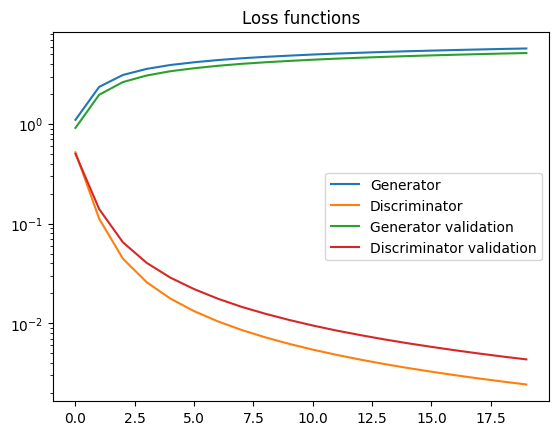

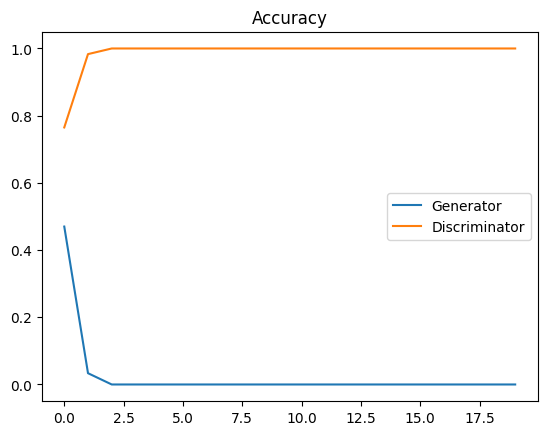

In [11]:
# Plot the training losses along the epochs
if model_struct == 'GAN_1':

    plt.plot(history1.history["gen_loss"], label="Generator")
    plt.plot(history1.history["discr_loss"], label="Discriminator")
    plt.plot(history1.history["gen_loss_val"], label="Generator validation")
    plt.plot(history1.history["discr_loss_val"], label="Discriminator validation")
    plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_pretrain.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history1.history["gen_acc"], label="Generator")
    plt.plot(history1.history["discr_acc"], label="Discriminator")
    plt.title("Accuracy")
    plt.legend()
    plt.savefig(model_dir + '/acc_pretrain.pdf')
    plt.show()

if model_struct == 'WGAN':

    plt.plot(history1.history["gen_loss"], label="Generator")
    plt.plot(history1.history["discr_loss"], label="Discriminator")
    plt.plot(history1.history["gen_loss_val"], label="Generator validation")
    plt.plot(history1.history["discr_loss_val"], label="Discriminator validation")
    # plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_pretrain.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history1.history["gen_response"], label="Generator")
    plt.plot(history1.history["discr_real_response"], label="Discriminator on real")
    plt.plot(history1.history["discr_synth_response"], label="Discriminator on synthetic")
    plt.title("Responses")
    plt.legend()
    plt.savefig(model_dir + '/resp_pretrain.pdf')
    plt.show()

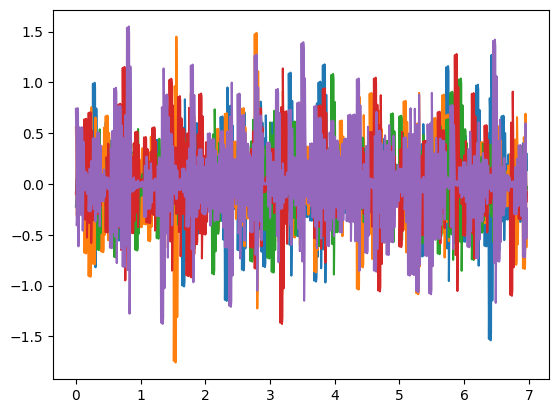

4/4 [==============================] - 0s 4ms/step


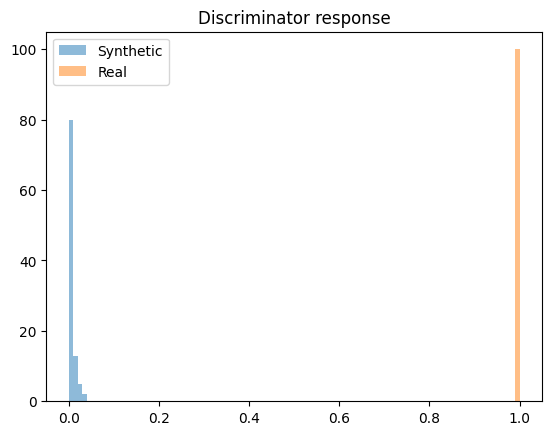

In [12]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(TODs_val.shape[0], inputnoise_bins))
test_synth_TODs = gan_pretrain.generator(test_inputnoise)

for i in range(5):
    plt.plot(time_steps[0,:,0], test_synth_TODs[i*TODs_val.shape[0]//5,:,0])
plt.show()

# TEst the Discriminator response for synthetic TOD
#test_response_synth = gan_toy.discriminator(test_synth_TODs)
#test_response_real = gan_toy.discriminator(TODs_val)
test_response_synth = gan_pretrain.discriminator.predict(test_synth_TODs)
test_response_real = gan_pretrain.discriminator.predict(TODs_val)
plt.hist(test_response_synth, label="Synthetic", range=(0,1), bins=100, alpha=0.5)
plt.hist(test_response_real, label="Real", range=(0,1), bins=100, alpha=0.5)
#plt.plot(test_response_synth - test_response_real, label="Difference")
plt.title("Discriminator response")
plt.legend()

plt.savefig(model_dir + '/response_pretrain.pdf')
plt.show()

#print(reduce_mean(test_response_real))
#print(reduce_mean(test_response_synth))
#print(reduce_mean(test_response_synth) - reduce_mean(test_response_real))

In [13]:
# Set the optimizers and train parameters
batch_size = 64
epochs = 500
lr_gen = 1e-2
lr_discr = 4*1e-4
momentum = 0.1
extra_discr = 1
synth_weight = 0.8
pretrain = True

# Optimizer
optim = 'Adam'

if optim == 'SGD':
    gen_optimizer = SGD(learning_rate=lr_gen, momentum=momentum)
    discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)
    
if optim == 'Nadam':
    gen_optimizer = Nadam(learning_rate=lr_gen)
    discr_optimizer = Nadam(learning_rate=lr_discr)

if optim == 'Adam':
    gen_optimizer = Adam(learning_rate=lr_gen)
    discr_optimizer = Adam(learning_rate=lr_discr)
    
if optim == 'Adam_SGD':
    gen_optimizer = Adam(learning_rate=lr_gen)
    discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)

if optim == 'SGD_Namam':
    gen_optimizer = SGD(learning_rate=lr_gen, momentum=momentum)
    discr_optimizer = Nadam(learning_rate=lr_discr)

if optim == 'Namam_SGD':
    gen_optimizer = Nadam(learning_rate=lr_gen)
    discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)

# Build the GAN
gen = real_generator_model(time_bins, inputnoise_bins, hit_len)
discr = real_discriminator_model(time_bins, hit_len)
if pretrain:
    discr.load_weights(model_dir + '/pretrained_discr.h5')
#mini_gan = mini_gan_model(gen, discr)
gen.summary()
discr.summary()

with open(model_dir + '/model_summary.txt', 'a') as f:
    gen.summary(print_fn=lambda x: f.write(x + '\n'))
    discr.summary(print_fn=lambda x: f.write(x + '\n'))

if model_struct == 'GAN_1':
    gan_toy = GAN_1(gen, discr, time_bins, inputnoise_bins)

if model_struct == 'WGAN':
    gan_toy = WGAN(gen, discr, time_bins, inputnoise_bins)

gan_toy.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight, extra_discr=extra_discr, val_data=TODs_val)

# Check of correct weights load
if pretrain:
    gan_toy_weights = gan_toy.discriminator.weights
    are_weights_equal = all([tf.reduce_all(w1 == w2) for w1, w2 in zip(gan_pretrain_weights, gan_toy_weights)])
    print('\nPre-trained discriminator weights loaded correctly:\t', are_weights_equal)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 265)               26765     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 265)               0         
                                                                 
 reshape_8 (Reshape)         (None, 265, 1)            0         
                                                                 
 conv1d_transpose_12 (Conv1  (None, 265, 8)            88        
 DTranspose)                                                     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 265, 8)            0         
                                                                 
 batch_normalization_17 (Ba  (None, 265, 8)            32        
 tchNormalization)                                       

In [14]:
# Train and validate the GAN
history2 = gan_toy.fit(TODs_train_cut, batch_size=batch_size, epochs=epochs)

Epoch 1/500
14/14 [==============================] - 6s 167ms/step - gen_loss: 0.3595 - discr_loss: 0.6620 - gen_loss_val: 6.2089 - discr_loss_val: 0.3298 - gen_acc: 0.0271 - discr_acc: 0.9221
Epoch 2/500
14/14 [==============================] - 2s 167ms/step - gen_loss: 0.2172 - discr_loss: 0.7531 - gen_loss_val: 9.5079 - discr_loss_val: 0.3587 - gen_acc: 0.0000e+00 - discr_acc: 0.9114
Epoch 3/500
14/14 [==============================] - 2s 166ms/step - gen_loss: 0.2071 - discr_loss: 0.7506 - gen_loss_val: 10.1736 - discr_loss_val: 0.3875 - gen_acc: 0.0000e+00 - discr_acc: 0.8975
Epoch 4/500
14/14 [==============================] - 2s 166ms/step - gen_loss: 0.2135 - discr_loss: 0.4786 - gen_loss_val: 10.4962 - discr_loss_val: 0.2423 - gen_acc: 0.0000e+00 - discr_acc: 0.9443
Epoch 5/500
14/14 [==============================] - 2s 162ms/step - gen_loss: 0.2158 - discr_loss: 0.2307 - gen_loss_val: 12.4100 - discr_loss_val: 0.1244 - gen_acc: 0.0000e+00 - discr_acc: 0.9914
Epoch 6/500
14/1

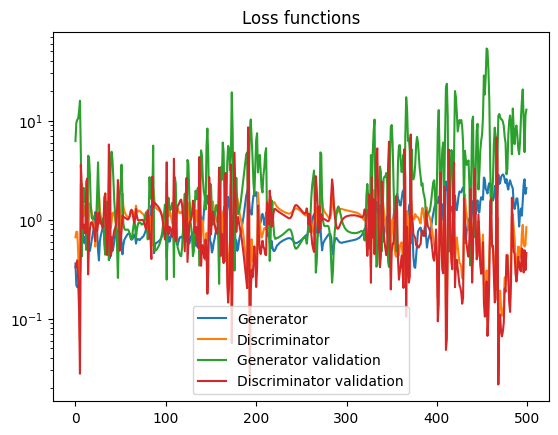

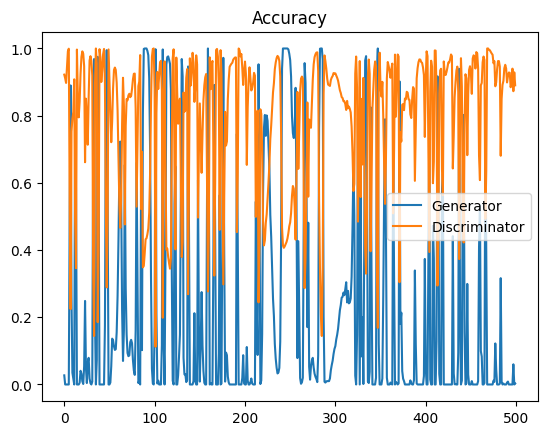

In [15]:
# Save the final model
gan_toy.generator.save(model_dir + '/final_generator.keras')
gan_toy.discriminator.save(model_dir + '/final_discriminator.keras')

# Plot the training losses along the epochs
if model_struct == 'GAN_1':

    plt.plot(history2.history["gen_loss"], label="Generator")
    plt.plot(history2.history["discr_loss"], label="Discriminator")
    plt.plot(history2.history["gen_loss_val"], label="Generator validation")
    plt.plot(history2.history["discr_loss_val"], label="Discriminator validation")
    plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_final.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history2.history["gen_acc"], label="Generator")
    plt.plot(history2.history["discr_acc"], label="Discriminator")
    plt.title("Accuracy")
    plt.legend()
    plt.savefig(model_dir + '/acc_final.pdf')
    plt.show()

if model_struct == 'WGAN':

    plt.plot(history2.history["gen_loss"], label="Generator")
    plt.plot(history2.history["discr_loss"], label="Discriminator")
    plt.plot(history2.history["gen_loss_val"], label="Generator validation")
    plt.plot(history2.history["discr_loss_val"], label="Discriminator validation")
    # plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_final.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history2.history["gen_response"], label="Generator")
    plt.plot(history2.history["discr_real_response"], label="Discriminator on real")
    plt.plot(history2.history["discr_synth_response"], label="Discriminator on synthetic")
    plt.title("Responses")
    plt.legend()
    plt.savefig(model_dir + '/resp_final.pdf')
    plt.show()

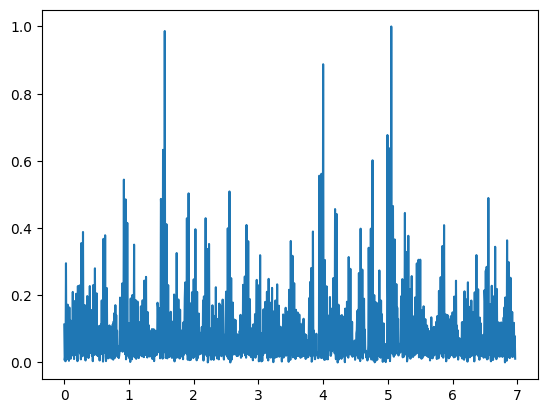

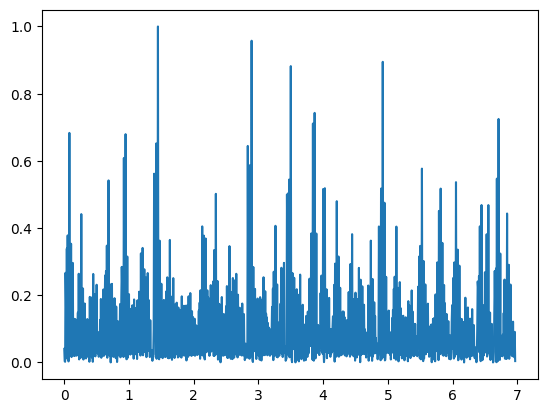

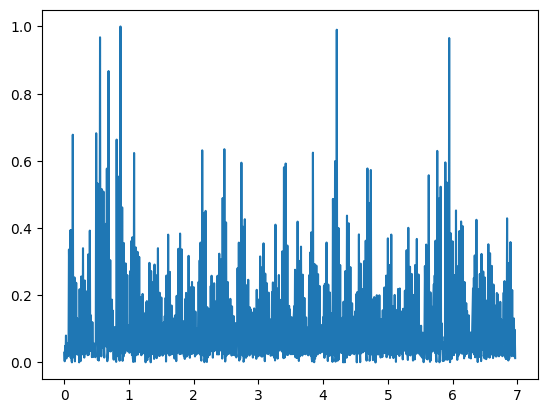

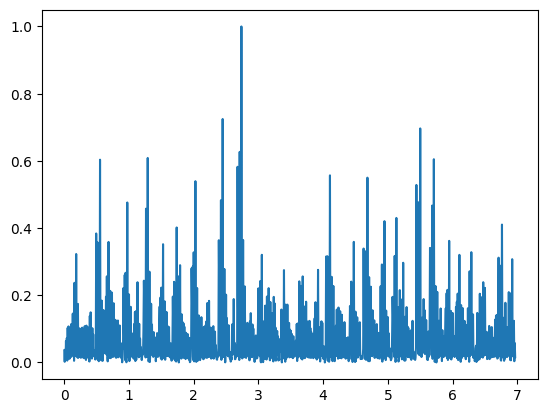

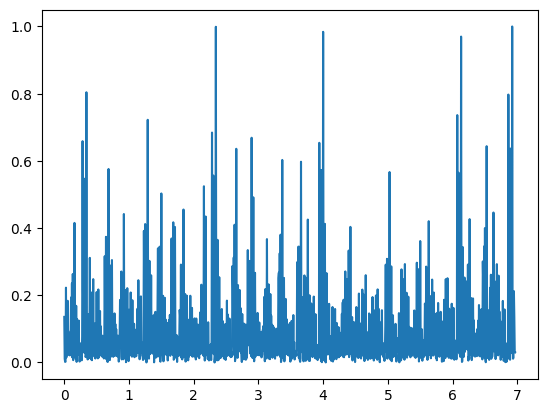

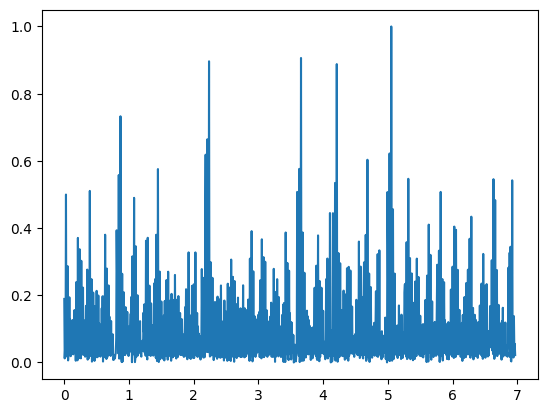

4/4 [==============================] - 0s 4ms/step


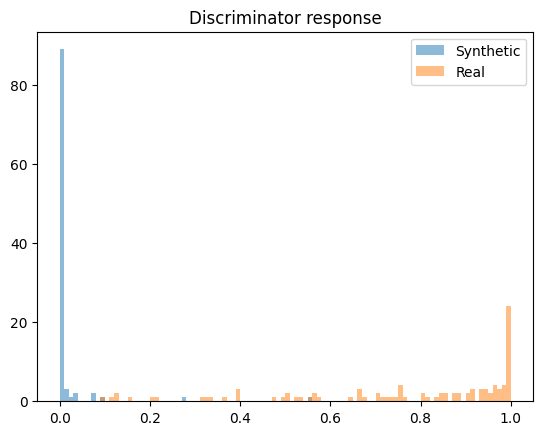

In [16]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(TODs_val.shape[0], inputnoise_bins))
test_synth_TODs = gan_toy.generator(test_inputnoise)

for i in range(5):
    plt.plot(time_steps[0,:,0], test_synth_TODs[i*TODs_val.shape[0]//5,:,0])
    plt.show()
plt.plot(time_steps[0,:,0], test_synth_TODs[TODs_val.shape[0]//2,:,0])
plt.savefig(model_dir + '/synth_TOD_exemple.pdf')
plt.show()

# TEst the Discriminator response for synthetic TOD
#test_response_synth = gan_toy.discriminator(test_synth_TODs)
#test_response_real = gan_toy.discriminator(TODs_val)
test_response_synth = gan_toy.discriminator.predict(test_synth_TODs)
test_response_real = gan_toy.discriminator.predict(TODs_val)
plt.hist(test_response_synth, label="Synthetic", range=(0,1), bins=100, alpha=0.5)
plt.hist(test_response_real, label="Real", range=(0,1), bins=100, alpha=0.5)
#plt.plot(test_response_synth - test_response_real, label="Difference")
plt.title("Discriminator response")
plt.legend()

plt.savefig(model_dir + '/response_test.pdf')
plt.show()

#print(reduce_mean(test_response_real))
#print(reduce_mean(test_response_synth))
#print(reduce_mean(test_response_synth) - reduce_mean(test_response_real))

In [17]:
'''# Clean previous models
clear_session()

# Save figure for poster
model_dir = '../models/simple_gan_12'
inputnoise_bins_poster = 100
gen_poster = load_model(model_dir + '/final_generator.keras', safe_mode=False)
poster_inputnoise = np.random.normal(size=(1, inputnoise_bins_poster))
poster_synth_TOD = gen_poster.predict(poster_inputnoise)
#poster_synth_TOD = denormalize(poster_synth_TOD, mins, maxs)
print(poster_inputnoise.shape)
print(poster_synth_TOD.shape)

plt.plot(time_steps[0,:,0], poster_synth_TOD[0,:,0])
plt.title('Synthetic TOD signal output')
plt.xticks(np.arange(0, 1561, step=156), labels=[str(i) for i in range(11)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized power')
plt.savefig(model_dir + '/synth_TOD_poster.jpg')
plt.show()'''

"# Clean previous models\nclear_session()\n\n# Save figure for poster\nmodel_dir = '../models/simple_gan_12'\ninputnoise_bins_poster = 100\ngen_poster = load_model(model_dir + '/final_generator.keras', safe_mode=False)\nposter_inputnoise = np.random.normal(size=(1, inputnoise_bins_poster))\nposter_synth_TOD = gen_poster.predict(poster_inputnoise)\n#poster_synth_TOD = denormalize(poster_synth_TOD, mins, maxs)\nprint(poster_inputnoise.shape)\nprint(poster_synth_TOD.shape)\n\nplt.plot(time_steps[0,:,0], poster_synth_TOD[0,:,0])\nplt.title('Synthetic TOD signal output')\nplt.xticks(np.arange(0, 1561, step=156), labels=[str(i) for i in range(11)])\nplt.xlabel('Time (s)')\nplt.ylabel('Normalized power')\nplt.savefig(model_dir + '/synth_TOD_poster.jpg')\nplt.show()"

(1060000,)


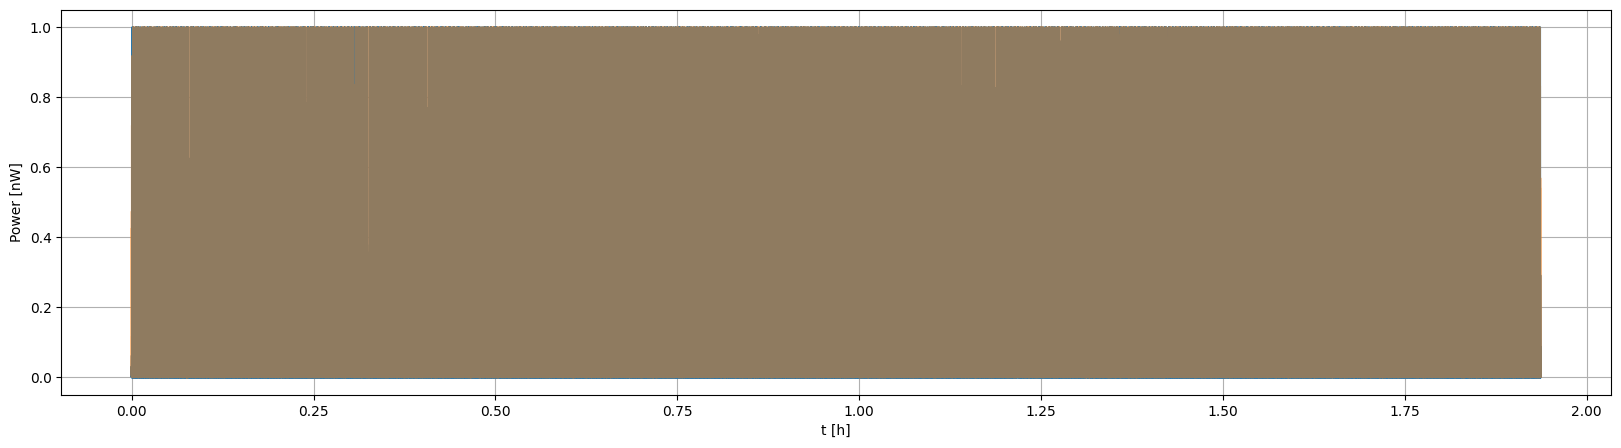

In [39]:
# Synthetic TOD sample production (THE BEST PRACTICE IS TO USE A SEPARETED TEST SAMPLE)
sample_dim = TODs_train.shape[0]+TODs_val.shape[0]
final_inputnoise = np.random.normal(size=(sample_dim, inputnoise_bins))
final_synth_TODs = gan_toy.generator(final_inputnoise)
final_real_TODs_train = TODs_train
final_real_TODs_val = TODs_val
sample_synth_TODs = final_synth_TODs[0]
sample_real_TODs = final_real_TODs_train[0]
sample_time_steps = time_steps[0]

for i in range(sample_dim-1):
    sample_synth_TODs = np.append(sample_synth_TODs, final_synth_TODs[i+1])

for i in range(TODs_train.shape[0]-1):
    sample_real_TODs = np.append(sample_real_TODs, final_real_TODs_train[i+1])
for i in range(TODs_val.shape[0]):
    sample_real_TODs = np.append(sample_real_TODs, final_real_TODs_val[i])

for i in range(sample_dim-1):
    sample_time_steps = np.append(sample_time_steps, time_steps[i+1])

# Comparison between generated and original TODs in amplitude and spectrogram
plt.figure(figsize=(20,5))
plt.plot(sample_time_steps/3600, sample_real_TODs)
plt.plot(sample_time_steps/3600, sample_synth_TODs, alpha=0.5)
plt.xlabel("t [h]")
plt.ylabel("Power [nW]")
plt.grid()
plt.show()